In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import pandas as pd
import random
import string
import numpy as np
import sys, os
import torch.utils.data as data

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'


all_characters = string.printable
number_of_characters = len(all_characters)


In [3]:
artists = [
'ABBA',
'Ace Of Base',
'Aerosmith',
'Avril Lavigne',
'Backstreet Boys',
'Bob Marley',
'Bon Jovi',
'Britney Spears',
'Bruno Mars',
'Coldplay',
'Def Leppard',
'Depeche Mode',
'Ed Sheeran',
'Elton John',
'Elvis Presley',
'Eminem',
'Enrique Iglesias',
'Evanescence',
'Fall Out Boy',
'Foo Fighters',
'Green Day',
 'HIM',
 'Imagine Dragons',
 'Incubus',
 'Jimi Hendrix',
 'Justin Bieber',
 'Justin Timberlake',
'Kanye West',
 'Katy Perry',
 'The Killers',
 'Kiss',
 'Lady Gaga',
 'Lana Del Rey',
 'Linkin Park',
 'Madonna',
 'Marilyn Manson',
 'Maroon 5',
 'Metallica',
 'Michael Bolton',
 'Michael Jackson',
 'Miley Cyrus',
 'Nickelback',
 'Nightwish',
 'Nirvana',
 'Oasis',
 'Offspring',
 'One Direction',
 'Ozzy Osbourne',
 'P!nk',
 'Queen',
 'Radiohead',
 'Red Hot Chili Peppers',
 'Rihanna',
 'Robbie Williams',
 'Rolling Stones',
 'Roxette',
 'Scorpions',
 'Snoop Dogg',
 'Sting',
 'The Script',
 'U2',
 'Weezer',
 'Yellowcard',
 'ZZ Top']


In [4]:
def character_to_label(character):
    """Returns a one-hot-encoded tensor given a character.
    
    Uses string.printable as a dictionary.
        
    Parameters
    ----------
    character : str
        A character
        
    Returns
    -------
    one_hot_tensor : Tensor of shape (1, number_of_characters)
        One-hot-encoded tensor
    """
    
    character_label = all_characters.find(character)
        
    return character_label


In [5]:
def string_to_labels(character_string):
    
    return map(lambda character: character_to_label(character), character_string)


In [6]:
def pad_sequence(seq, max_length, pad_label=100):
    
    seq += [pad_label for i in range(max_length - len(seq))]
    
    return seq


In [7]:
class LyricsGenerationDataset(data.Dataset):
    
    def __init__(self, csv_file_path, minimum_song_count=None, artists=None):
        
        
        self.lyrics_dataframe = pd.read_csv(csv_file_path)
        
        if artists:
            
            self.lyrics_dataframe = self.lyrics_dataframe[self.lyrics_dataframe.artist.isin(artists)]
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        if minimum_song_count:
        
            # Getting artists that have 70+ songs
            self.lyrics_dataframe = self.lyrics_dataframe.groupby('artist').filter(lambda x: len(x) > minimum_song_count)
            # Reindex .loc after we fetched random songs
            self.lyrics_dataframe = self.lyrics_dataframe.reset_index()
        
        # Get the length of the biggest lyric text
        # We will need that for padding
        self.max_text_len = self.lyrics_dataframe.text.str.len().max()
        
        whole_dataset_len = len(self.lyrics_dataframe)
        
        self.indexes = range(whole_dataset_len)
        
        
        # Let's get unique artists and form a list
        self.artists_list = list(self.lyrics_dataframe.artist.unique())
        
        # We will need the overall number of artists for 
        self.number_of_artists = len(self.artists_list)
    
    
    def __len__(self):
        
        return len(self.indexes)
    
    
    def __getitem__(self, index):
        
        index = self.indexes[index]
        
        sequence_raw_string = self.lyrics_dataframe.loc[index].text
        
        sequence_string_labels = string_to_labels(sequence_raw_string)
        
        sequence_length = len(sequence_string_labels) - 1
        
        # Shifted by one char
        input_string_labels = sequence_string_labels[:-1]
        output_string_labels = sequence_string_labels[1:]
                
        # pad sequence so that all of them have the same lenght
        # Otherwise the batching won't work
        input_string_labels_padded = pad_sequence(input_string_labels, max_length=self.max_text_len)
        
        output_string_labels_padded = pad_sequence(output_string_labels, max_length=self.max_text_len, pad_label=-100)
        
        ## Adding the artist label
        sequence_raw_artist_name_string = self.lyrics_dataframe.loc[index].artist

        sequence_artist_label = self.artists_list.index(sequence_raw_artist_name_string)
        
        return (torch.LongTensor(input_string_labels_padded),
                torch.LongTensor(output_string_labels_padded),
                torch.LongTensor([sequence_artist_label]),
                torch.LongTensor([sequence_length]) )



In [8]:
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, artists, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_artists_batch = artists.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_artists_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[3]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_artists_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    artists_batch_sorted = torch.cat(splitted_artists_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    
    # Here we trim overall data matrix using the size of the longest sequence
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, :lengths_batch_sorted[0, 0]]
    
    # We should probably repeat this over the whole input sequence
    artists_batch_sorted = artists_batch_sorted.expand_as(input_sequence_batch_sorted)

    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    artists_batch_sorted_transposed = artists_batch_sorted.transpose(0, 1)
    
    # pytorch's api for rnns wants lenghts to be list of ints
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, artists_batch_sorted_transposed, lengths_batch_sorted_list



In [9]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, num_conditions, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        self.num_conditions = num_conditions
        
        # Converts labels into one-hot encoding and runs a linear
        # layer on each of the converted one-hot encoded elements
        
        # input_size -- size of the dictionary + 1 (accounts for padding constant)
        self.characters_encoder = nn.Embedding(input_size, hidden_size)
        
        self.conditions_encoder = nn.Embedding(num_conditions, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size * 2, hidden_size, n_layers)
        
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_conditions, input_sequences_lengths, hidden=None):
        
        batch_size = input_sequences.shape[1]

        characters_encoded = self.characters_encoder(input_sequences)
        conditions_endoded = self.conditions_encoder(input_sequences_conditions)
        
        encodings_combined = torch.cat((characters_encoded, conditions_endoded), dim=2)

        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(encodings_combined, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs) # unpack (back to padded)
        
        logits = self.logits_fc(outputs)
        
        logits = logits.transpose(0, 1).contiguous()
        
        logits_flatten = logits.view(-1, self.num_classes)
        
        return logits_flatten, hidden



In [10]:
trainset = LyricsGenerationDataset(csv_file_path='songdata.csv', artists=artists)

trainset_loader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                              shuffle=True, num_workers=4, drop_last=True)


In [11]:
rnn = RNN(input_size=len(all_characters) + 1,
          hidden_size=512,
          num_classes=len(all_characters),
          num_conditions=trainset.number_of_artists)

rnn.cuda()


RNN(
  (characters_encoder): Embedding(101, 512)
  (conditions_encoder): Embedding(64, 512)
  (lstm): LSTM(1024, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=100)
)

In [12]:
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss().cuda()


In [13]:
def sample_from_rnn_conditionally(starting_sting="Why", sample_length=300, temperature=1, artist_label=0):
    
    sampled_string = starting_sting
    hidden = None

    first_input = torch.LongTensor( string_to_labels(starting_sting) ).cuda()
    first_input = first_input.unsqueeze(1)

    # Expand the artist label to have the same size as input sequence
    # we duplicate it in every input
    artist_label_input = torch.LongTensor([artist_label]).expand_as(first_input)

    current_sequence_input = Variable(first_input)
    current_artist_input = Variable(artist_label_input.cuda())

    output, hidden = rnn(current_sequence_input, current_artist_input, [len(sampled_string)], hidden=hidden)

    output = output[-1, :].unsqueeze(0)

    for i in xrange(sample_length):

        output_dist = nn.functional.softmax( output.view(-1).div(temperature) ).data

        predicted_label = torch.multinomial(output_dist, 1)

        sampled_string += all_characters[int(predicted_label[0])]
        current_sequence_input = Variable(predicted_label.unsqueeze(1))

        artist_label_input = torch.LongTensor([artist_label]).expand_as(current_sequence_input)
        current_artist_input = Variable(artist_label_input.cuda())

        output, hidden = rnn(current_sequence_input, current_artist_input, [1], hidden=hidden)
    
    return sampled_string

<IPython.core.display.Javascript object>


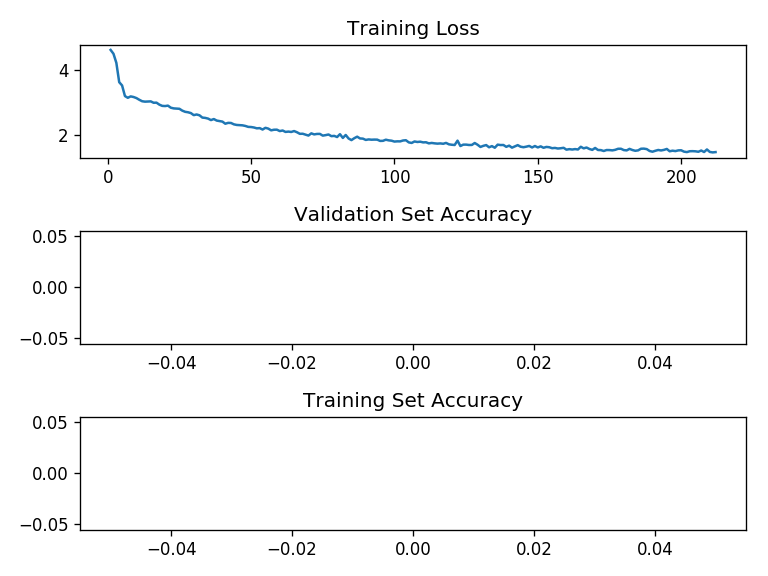

In [14]:
%matplotlib notebook

from matplotlib import pyplot as plt

# importing a list that can be binded with a figure and update
# the figure when being appended
from visualization import VizList

# Creating figure, axes and binding to lists 
f, (loss_axis, validation_axis, train_axis) = plt.subplots(3, 1)

loss_axis.plot([], [])
validation_axis.plot([], [])
train_axis.plot([], [])


loss_list = VizList()
validation_list = VizList()
train_list = VizList()

loss_list.bind_to_axis(loss_axis)
validation_list.bind_to_axis(validation_axis)
train_list.bind_to_axis(train_axis)

loss_axis.set_title('Training Loss')
validation_axis.set_title('Validation Set Accuracy')
train_axis.set_title('Training Set Accuracy')


plt.tight_layout()

In [ ]:
clip = 1.0
epochs_number = 1000

for epoch_number in xrange(epochs_number):

    for batch in trainset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, artists_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )
        
        
        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )
        artists_batch_var = Variable( artists_batch.cuda() )
        
        optimizer.zero_grad()

        logits, _ = rnn(input_sequences_batch_var, artists_batch_var, sequences_lengths)
        
        loss = criterion(logits, output_sequences_batch_var)
        loss_list.append( loss.data[0] )
        loss.backward()

        #torch.nn.utils.clip_grad_norm(rnn.parameters(), clip)

        optimizer.step()
        
    print(sample_from_rnn_conditionally(artist_label=trainset.artists_list.index("Kanye West")))
    torch.save(rnn.state_dict(), 'results/conditional_rnn.pth')
    

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Why best)  
And I was your sack out that to every mind to  
The dingwer preest me  
Wit and what that you shom thoure  
But you just kiy don't ppieggiy freamy, this show trukes  
Brarveryming buin  
Tackif)  
[M! some frath rofts I finfories and  
Massy drewly crristerk this out the were you  
She's pe


Ideally run till about 150000 iterations.... It will take for a while